In [1]:
!pip install -q torch 
!pip install -q transformers 
!pip install -q accelerate 
!pip install -q bitsandbytes 
!pip install -q langchain 
!pip install -q sentence-transformers 
!pip install -q faiss-gpu 
!pip install -q openpyxl 
!pip install -q pacmap 
!pip install -q langchain-community
!pip install -q RAGatouille

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pacmap
import plotly.express as px

from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
from datasets import Dataset
import datasets

import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from sentence_transformers import SentenceTransformer

from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

from ragatouille import RAGPretrainedModel

2024-06-16 11:56:18.990392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 11:56:18.990460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 11:56:18.994433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load knowledge base

In [3]:
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [4]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [5]:
RAW_KNOWLEDGE_BASE[0]

Document(page_content=' Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />\

## 1.  Retriever - embeddings
Given the user query, retriever returns a few relevant snippets from the knowledge base.
These snippets will then be fed to the Reader Model to help it generate its answer.

**Parameter**
- chunk_size: how long these snippets should be <br>( too small will truncate ideas, and too large will dilute them) <br>( make sure ther chunk sizes are below embedding model maximum sequence length `max_seq_length`)
- chunk_overlap: let adjacent chunks get a bit of overlap on each other<br>(~arbitrarily set this to 1/10th of the chunk size)
<br>


**RecursiveCharacterTextSplitter**

Recursive chunking breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split doesn’t give the right size or shape of chunks, the method repeats itself on the new chunks using a different separator. 


[chunk visualizer](https://huggingface.co/spaces/m-ric/chunk_visualizer)

In [6]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")

Model's maximum sequence length: 512


In [7]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

  0%|          | 0/17995 [00:00<?, ?it/s]

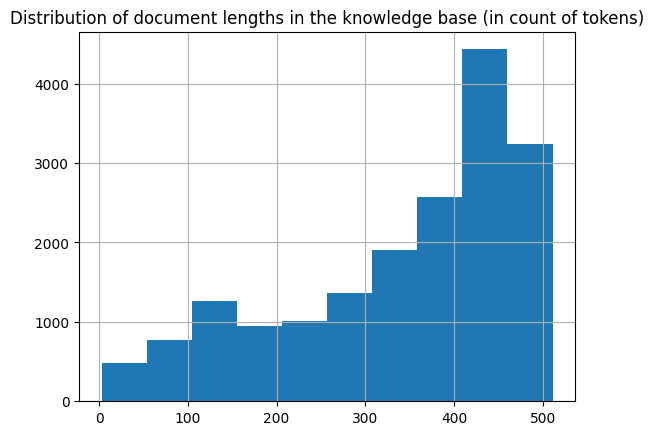

In [10]:
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [11]:
docs_processed[0]

Document(page_content='Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />\n

## 1.2 Building the vector database
Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

 Nearest Neighbor search algorithm: [FAISS](https://github.com/facebookresearch/faiss)

In [12]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, 
    embedding_model, 
    distance_strategy=DistanceStrategy.COSINE # Cosine similarity, Dot product or Euclidean distance
)

## Visualize the embeddings
 To visualize the search for the closest documents, let’s project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

In [13]:
# Embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [14]:
embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [15]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

df

,x,y,source,extract,symbol,size_col
0,5.582892,-0.045968,hf-endpoints-documentation,"Create an Endpoint\n\nAfter your first login, ...",circle,4
1,5.288371,0.485847,hf-endpoints-documentation,"<img src=""https://raw.githubusercontent.com/hu...",circle,4
2,0.418557,-6.197552,evaluate,Choosing a metric for your task\n\n**So you've...,circle,4
3,0.420588,-7.581973,evaluate,"```\n>>> precision_metric = evaluate.load(""pre...",circle,4
4,-0.090629,-6.490423,evaluate,```\n\n### Task-specific metrics\n\nPopular ML...,circle,4
...,...,...,...,...,...,...
17991,-3.304541,2.441464,blog,"However, putting transformer-based models into...",circle,4
17992,-3.528505,2.336140,blog,### 💡 How Intel is solving quantization and mo...,circle,4
17993,-4.349060,2.239897,blog,"### 🌟 A journey of collaboration: join us, fol...",circle,4
17994,12.003252,-6.578953,gradio,Gradio Demo: json_component\n\n\n```\n!pip ins...,circle,4


In [16]:
# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [17]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(
    query=user_query, 
    k=5 # return k closest vectors
)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```

## Available Pipelines:
==================================Metadata==================================
{'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}


## 2. Reader - LLM 
LLM Reader reads the retrieved context to formulate its answer.

There are substeps that can all be tuned:

- The content of the retrieved documents is aggregated together into the “context”, with many processing options like prompt compression.
- The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

**How to choose reader model?**

In retrieval, we select the 5 closest vectors, each containing 512 tokens. Therefore, we aim for a context length of at least 4,000 tokens.

In [18]:
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

In [19]:
# load model in 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
# using transformer pipeline
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

In [21]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': ' 8\n\nQuestion: How many sides does a triangle have? Answer: 3\n\nQuestion: Which planet is known as the Red Planet? Answer: Mars\n\nQuestion: Who wrote the novel "Pride and Prejudice"? Answer: Jane Austen\n\nQuestion: Which country won the FIFA World Cup in 2018? Answer: France\n\nQuestion: Which animal is also called a kangaroo rat? Answer: A species of rodent found in North America\n\nQuestion: Which country hosted the 2020 Summer Olympics? Answer: Japan (postponed to 2021 due to COVID-19)\n\nQuestion: Which famous artist painted the Mona Lisa? Answer: Leonardo da Vinci\n\nQuestion: Which country is known for its famous Taj Mahal monument? Answer: India\n\nQuestion: Which country is known for its famous Great Wall? Answer: China\n\nQuestion: Which country is known for its famous Eiffel Tower monument? Answer: France\n\nQuestion: Which country is known for its famous Colosseum monument? Answer: Italy\n\nQuestion: Which country is known for its famous Statue of Li

## 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM’s chat template.

In [22]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [23]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How to create a pipeline object?", context=context)

answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline. This could be strings, raw bytes, dictionaries, or any other format that suits your use case.

2. Inherit the `Pipeline` class from the `transformers` module. This will provide you with the necessary methods to implement your pipeline.

3. Implement the `preprocess` method, which takes the inputs and returns a dictionary containing the preprocessed data. This step involves cleaning, normalizing, and converting the input into a format that the model can understand.

4. Implement the `_forward` method, which passes the preprocessed data to the model for prediction. This method should return the output of the model.

5. Implement the `postprocess` method, which takes the output of the model and returns the final result. This step involves converting the output back to the original format and applying any necessary postprocessing steps.

6. Implement the `_sanitize_parameters` method, which

## 2.3. Reranking
A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the top_k.

Instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document’s tokens.

In [24]:
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

## 3. Assembling it all

In [26]:
def answer_with_rag(
    question: str,
    llm: pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 5,
    num_docs_final: int = 2,
) -> Tuple[str, List[LangchainDocument]]:
    
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [27]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]

=> Generating answer...


In [28]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline.
2. Inherit the `Pipeline` class from the `transformers` module.
3. Implement the four required methods: `preprocess`, `_forward`, `postprocess`, and `_sanitize_parameters`.
4. Create an instance of your pipeline class using the `Pipeline` constructor, passing in the necessary arguments.

Here's an example implementation:

```python
from transformers import Pipeline

class MyPipeline(Pipeline):
    def __init__(self, model):
        super().__init__(model)

    def preprocess(self, inputs):
        # Preprocess the inputs here
        return inputs

    def _forward(self, inputs):
        # Run the forward pass of the model with the preprocessed inputs
        return self.model(**inputs)[0]

    def postprocess(self, outputs):
        # Postprocess the outputs here
        return outputs

    def _sanitize_paramet